In [18]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm
from tqdm.contrib import tzip

In [19]:
X = datasets.make_moons(n_samples=500,noise=0.11,random_state=0,shuffle=False)
X = list(X)[0]
X = np.asarray(X)
X

array([[ 1.19404576e+00,  4.40172929e-02],
       [ 1.10758159e+00,  2.59114755e-01],
       [ 1.20511303e+00, -8.22695686e-02],
       [ 1.10379348e+00,  2.11921838e-02],
       [ 9.87372720e-01,  9.56117668e-02],
       [ 1.01385565e+00,  2.23012442e-01],
       [ 1.08085020e+00,  8.90129977e-02],
       [ 1.04492747e+00,  1.24907273e-01],
       [ 1.15925911e+00,  7.81959980e-02],
       [ 1.02799740e+00,  1.93571463e-02],
       [ 7.11222443e-01,  1.97731957e-01],
       [ 1.08547276e+00,  5.67019628e-02],
       [ 1.23823359e+00, -9.15592704e-03],
       [ 9.91612466e-01,  1.42694247e-01],
       [ 1.15304614e+00,  3.37348117e-01],
       [ 9.99189337e-01,  2.29722740e-01],
       [ 8.82037039e-01, -1.73864851e-02],
       [ 9.38815537e-01,  2.30043861e-01],
       [ 1.10965472e+00,  3.57417724e-01],
       [ 9.28798562e-01,  2.04177264e-01],
       [ 8.52990827e-01,  9.34654238e-02],
       [ 7.77414932e-01,  4.76449778e-01],
       [ 9.05662285e-01,  2.25831716e-01],
       [ 8.

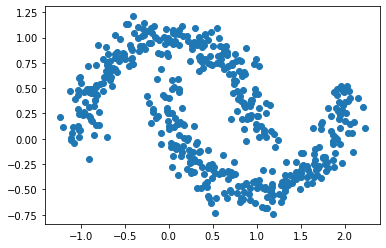

In [20]:
plt.scatter(X[:,0],X[:,1])
plt.show()

In [21]:
def calc_mu(x):
    sum = np.zeros([2,])
    for i in range(len(x)):
        sum += x[i]
    return sum/len(x)

def calc_sigma(x,mu):
    sum = np.zeros([2,2])    
    for i in range(len(x)):
        temp = x[i]-mu
        a, b = temp.reshape(2,1),  temp.reshape(1,2)
        sum += (a*b)       
    return sum/len(x)

def gaus_dist(x):
    mu = []
    sigma = []
    mu.extend((calc_mu(x[:250]), calc_mu(x[250:])))       
    sigma.extend((calc_sigma(x[:250],mu[0]), calc_sigma(x[250:],mu[1])))
    return mu,sigma

In [22]:
gaus_mu,gaus_sigma = gaus_dist(X)

In [45]:
print('MU = ', gaus_mu[0])
print('SIGMA = ', gaus_sigma[0])

MU =  [-0.00587799  0.63436489]
SIGMA =  [[0.51864846 0.00414387]
 [0.00414387 0.10601979]]


In [46]:
print('MU = ', gaus_mu[1])
print('SIGMA = ', gaus_sigma[1])

MU =  [ 0.99149754 -0.13989739]
SIGMA =  [[0.53000241 0.00749826]
 [0.00749826 0.1136647 ]]


In [47]:
def plot_data(means_vec, covariances_mtx, features, k):
    #Return coordinate matrices from coordinate vectors
    x,y = np.meshgrid(np.sort(features[:,0]),np.sort(features[:,1]))
    x_t = np.array([x.flatten(),y.flatten()]).T 
    plt.scatter(features[:,0],features[:,1],
               marker='o', c='black')
    plt.title(f'GMM Moons (n = {k})')
    for m, c in tzip(means_vec, covariances_mtx):
        multi_normal = multivariate_normal(mean=m,cov=c)
        plt.contour(np.sort(features[:,0]), np.sort(features[:,1]),
                    multi_normal.pdf(x_t).reshape(len(features),len(features)),
                    colors='blue')
    plt.legend()

  0%|          | 0/2 [00:00<?, ?it/s]

No handles with labels found to put in legend.


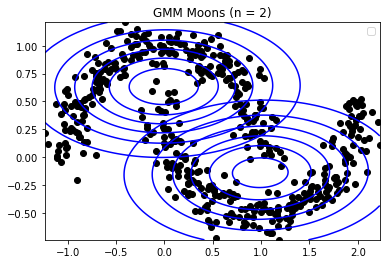

In [49]:
plot_data(gaus_mu, gaus_sigma, X , 2)

In [27]:
def normal_dist(x, mu, covariance):
    return  (2*np.pi)**(-len(x)/2)*np.linalg.det(covariance)**(-1/2)*np.exp(-np.dot(np.dot((x-mu).T, np.linalg.inv(covariance)), (x-mu))/2)

def p_j(inp, mu, sigma, coef, z, k):
    nominator = normal_dist(inp,mu[z],sigma[z])
    denominator = 0
    for j in range(k):
        denominator += normal_dist(inp,mu[j],sigma[j])   
    return coef[z] * nominator/denominator 

def get_sigma(x, mu, p):
    nominator = 0 
    denominator = 0
    for i in range(len(x)):        
        a = (x[i,:] - mu).reshape(2,1)
        b = (x[i,:] - mu).reshape(1,2)  
        nominator   += p[i] * (a.dot(b))
        denominator += p[i]
    return nominator / denominator

def get_mu(x, p):
    nominator = 0 
    denominator = 0 
    for i in range(len(x)):
        nominator += p[i] * x[i]
        denominator += p[i]
    return nominator / denominator

def get_coef(x, p, idx, k): 
    nominator = 0
    denominator = 0
    for i in range(len(x)):
        nominator += p[i, idx]
        for j in range(k):
            denominator += p[i,j]
    return nominator/denominator

In [39]:
def find_GMM(x,k ,max_iter = 40):
    # Initialization
    temp = np.array_split(x, k)    
    np.random.seed(2)
    coef_0 = [1/k for c in range(k)]
    mu_0 = [np.random.uniform(low=-0.5, high=1, size=(2,)) for c in range(k)]
    sigma_0 = [np.cov(temp[c].T) for c in range(k)]
    # Calculate New parameters
    coef_new = coef_0 
    mu_new = mu_0
    sigma_new = sigma_0 
    # Iteration
    for iteration in tqdm(range(max_iter)):    
        coef_g = coef_new
        mu_g = mu_new
        sigma_g = sigma_new
        # Update p_j
        p = np.zeros([len(x),k]) 
        for row in range(len(x)):
            for c in range(k):
                p[row, c] = p_j(x[row,:], mu_g, sigma_g, coef_g, c, k)
        # Update parameters
        coef_new = []
        mu_new = []
        sigma_new = []
        for c in range(k):
            coef_new.append(get_coef(x, p, c, k))
            mu_new.append(get_mu(x, p[:,c]))
            sigma_new.append(get_sigma(x, mu_g[c], p[:,c]))
    return coef_new, mu_new, sigma_new

In [40]:
coef, mu, sigma =[0,0,0],[0,0,0],[0,0,0]

for i,n in tzip(range(3),[3,8,16]):
    print('K =', n)
    coef[i], mu[i], sigma[i] = find_GMM(X,k=n,max_iter=40)
    print('Done!\n')

  0%|          | 0/3 [00:00<?, ?it/s]

K = 3



100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


Done!

K = 8



100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [03:00<00:00,  4.51s/it]


Done!

K = 16



100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [11:09<00:00, 16.73s/it]

Done!



  0%|          | 0/3 [00:00<?, ?it/s]

No handles with labels found to put in legend.


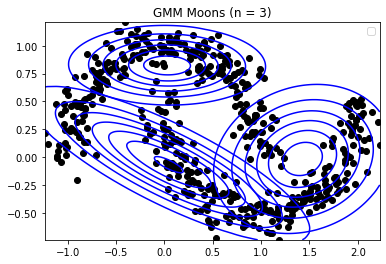

In [50]:
plot_data(mu[0],sigma[0],X,3)

  0%|          | 0/8 [00:00<?, ?it/s]

No handles with labels found to put in legend.


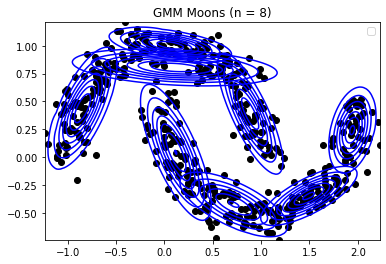

In [51]:
plot_data(mu[1],sigma[1],X,8)

  0%|          | 0/16 [00:00<?, ?it/s]

No handles with labels found to put in legend.


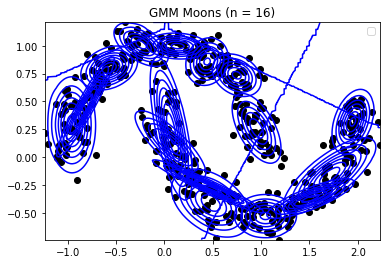

In [52]:
plot_data(mu[2],sigma[2],X,16)